# Why Are Our Customers Churning?

**1.** [**Project Plan**](#Project-Plan)<br>
**2.** [**Acquire and Split Data**](#acquire_and_split_data)<br>
**3.** [**Explore Data**](#explore_data)<br>
**4.** [**Create a Baseline Model**](#baseline_model)<br>
**5.** [**Create and Compare Different Models**](#modeling)<br>
**6.** [**Predict on Test Model**](#predict_test)<br>
**7.** [**Exporting CSV with Predictions**](#csv_export)

## 1. Project Plan

### Background

Our team leader wants us to find out why our customers are churning.

> Our team lead would like us to take a look at some of our recent customer data. We've been tasked with identifying areas that represent high customer churn.

> Aside from the more general question, *why are our customers churning?* Some other questions we will look to answer: Is there a price threshold for specific services where the likelihood of churn increases? Is their a negative impact once the price for those services goes past that point? If so, what is that point for what service(s)? Among numerous other possible questions.

> For this particular project she would like to see our code documentation and commenting buttoned-up. In addition, she'd like us to not leave any individual numbers or figures displayed in isolation. Adding context to these situations are necessary.

### Goals

To identify as many different customer subgroups that have a propensity to churn more than others. Our target audience is our team lead, however, she will be presenting these findings to the Senior Leadership Team. We will need to keep this final audience in mind with regards to report readability, etc. We will need to communicate in a more concise and clear manner.

The deliverables for this project are the following data assets:

1. Report detailing our analysis in an .ipynb format
2. A CSV with the customer_id, probability of churn, and the prediction of churn
3. Slide Deck explaining our analysis with the SLT audience in mind
4. All .py files that are necessary to reproducible work
5. Detailed README on a Github and repo containing all files for this project

### Data Dictionary for Selected Features

#### *Target Variable*:

**churn** - defines whether or not the customer is still with telco: 0 == still with telco, 1 == they have churned


#### *Independent Variables*:

**gender** - gender identity of customer - 0 = female, 1 = male

**senior_citizen** - if the customer is a senior - 0 = not senior citizen, 1 = senior citizen

**online_security** - if the customer has online security through telco - 0 = No, 1 = No Internet Service, 2 = Yes

**online_backup** - if the customer has online backup through telco - 0 = No, 1 = No Internet Service, 2 = Yes

**device_protection** - if the customer has device protection through telco - 0 = No, 1 = No Internet Service, 2 = Yes

**tech_support** - if the customer has tech support through telco - 0 = No, 1 = No Internet Service, 2 = Yes

**streaming_tv** - if the cusomter has streaming tv service through telco - 0 = No, 1 = No Internet Service, 2 = Yes

**streaming_movies** - if the cusomter has streaming movie service through telco - 0 = No, 1 = No Internet Service, 2 = Yes

**paperless_billing** - if the customer has elected to have a paperless billing format - 0 = No, 1 =Yes

**monthly_charges** - the monthly charges per customer for all services - represented as a float, calculated in USD

**total_charges** - the total lifetime charges per customer for all services - represented as a float, calculated in USD

**tenure_years** - tenure of each customer - represented in total years, used the tenure (calculated in months) column from original data pull then divided by 12.

**phone_and_multi_line** - a combination of whether a customer has a phone line, and if they do, do they have multiple lines (used the phone_service and multipe_line columns from original pull) - 0 = No phone lines, 1 = Yes, but only one line, 2 = Yes, multiple lines

**partner_and_dependents** - a combination of whether a customer has a partner or dependents (used the partner and dependents columns from original pull) - 0 = No partner and No dependents, 1 = Yes, a partner and No dependents, 2 = No partner and Yes, dependents, 3 = Yes, partner and Yes, dependents

**Electronic check** - the customer pays with Electronic check, one hot encoded from the payment_types column from original pull - 0 = No, 1 = Yes

**Mailed check** -the customer pays with Mailed check, one hot encoded from the payment_types column from original pull - 0 = No, 1 = Yes

**Credit card (automatic)** - the customer pays with Credit card, one hot encoded from the payment_types column from original pull - 0 = No, 1 = Yes

**Bank transfer (automatic)** - the customer pays with Bank transfer, one hot encoded from the payment_types column from original pull - 0 = No, 1 = Yes

**DSL** - the customer has DSL internet service, one hot encoded from the internet_types column from original pull - 0 = No, 1 = Yes

**Fiber optic** - the customer has Fiber optic internet service, one hot encoded from the internet_types column from original pull - 0 = No, 1 = Yes

**None** - the customer does not have internet service, one hot encoded from the internet_types column from original pull - 0 = No, 1 = Yes

**Month-to-month** - the customer pays Month-to-month, one hot encoded from the contract_types column from original pull - 0 = No, 1 = Yes

**One year** - the customer pays Month-to-month, one hot encoded from the contract_types column from original pull - 0 = No, 1 = Yes

**Two year** - the customer pays Month-to-month, one hot encoded from the contract_types column from original pull - 0 = No, 1 = Yes

#### *Data Scaling*:

**Min/Max Scaler** - The deliverables requires we proved a model that preforms better than the baseline at predicting customer churn. We'll be using Classification models to make this prediciton. It's possible we'll need to scale the data, generally; however, a model like K Nearest Neighbors requires scaling, so we'll at least be scaling when testing that model.

In [49]:
import numpy as np
import pandas as pd
from math import sqrt
from scipy import stats
import itertools

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
import sklearn.impute
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import env
import acquire
import prepare

pd.set_option('display.max_columns', None)

<a id='acquire_and_split_data'></a>

# 2. Acquire and Split Data

In [2]:
# We're be pulling the telco data from our SQL servers. You'll need the acquire.py file and an env.py file for
# this data pull.

telco = acquire.get_telco_data()

### Let's take a look at the data

In [3]:
telco.head(10)

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,No,No,No,No,No,Yes,No,59.90,542.4,No,Month-to-month,DSL,Mailed check
1,4,1,1,0013-MHZWF,Female,0,No,Yes,9,Yes,No,No,No,No,Yes,Yes,Yes,Yes,69.40,571.45,No,Month-to-month,DSL,Credit card (automatic)
2,1,1,1,0015-UOCOJ,Female,1,No,No,7,Yes,No,Yes,No,No,No,No,No,Yes,48.20,340.35,No,Month-to-month,DSL,Electronic check
3,1,1,1,0023-HGHWL,Male,1,No,No,1,No,No phone service,No,No,No,No,No,No,Yes,25.10,25.1,Yes,Month-to-month,DSL,Electronic check
4,3,1,1,0032-PGELS,Female,0,Yes,Yes,1,No,No phone service,Yes,No,No,No,No,No,No,30.50,30.5,Yes,Month-to-month,DSL,Bank transfer (automatic)
5,1,1,1,0067-DKWBL,Male,1,No,No,2,Yes,No,Yes,No,No,No,No,No,Yes,49.25,91.1,Yes,Month-to-month,DSL,Electronic check
6,2,1,1,0076-LVEPS,Male,0,No,Yes,29,No,No phone service,Yes,Yes,Yes,Yes,No,No,Yes,45.00,1242.45,No,Month-to-month,DSL,Mailed check
7,2,1,1,0082-LDZUE,Male,0,No,No,1,Yes,No,No,No,No,No,No,No,Yes,44.30,44.3,No,Month-to-month,DSL,Mailed check
8,1,1,1,0096-BXERS,Female,0,Yes,No,6,Yes,Yes,No,No,No,No,No,No,No,50.35,314.55,No,Month-to-month,DSL,Electronic check
9,2,1,1,0096-FCPUF,Male,0,No,No,30,Yes,Yes,Yes,No,No,No,No,Yes,Yes,64.50,1888.45,No,Month-to-month,DSL,Mailed check


In [4]:
telco.shape

(7043, 24)

In [5]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [6]:
telco.describe()

,payment_type_id,internet_service_type_id,contract_type_id,senior_citizen,tenure,monthly_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,2.315633,1.872923,1.690473,0.162147,32.371149,64.761692
std,1.148907,0.737796,0.833755,0.368612,24.559481,30.090047
min,1.000000,1.000000,1.000000,0.000000,0.000000,18.250000
25%,1.000000,1.000000,1.000000,0.000000,9.000000,35.500000
50%,2.000000,2.000000,1.000000,0.000000,29.000000,70.350000
75%,3.000000,2.000000,2.000000,0.000000,55.000000,89.850000
max,4.000000,3.000000,3.000000,1.000000,72.000000,118.750000


#### Takeaways

- total_charges should be in the above .describe(), but it is the wrong dtype

- After seveeral attempts to change total_charges into a float, we discovered there were some empty spaces in the cell, so once we replace those, we can now see a few missing values there as well, and we can change the dtype

- We decided to drop the 0 values (found in the total_charges column) from the data set, because we have plenty of data points for our analysis, and these customers haven't even had a chance to churn yet.

- After viewing the data post this change, we felt like keeping the customer_id was vital, but we'd like to 'take it out' of the data for future scaling, exploration, etc. So, we will set the index with the customer_id

- We have a ton of variables that are related, so we're looking to combine a few columns into single 'encoded' variables, the first combination was whether a customer has phone service at all, and if they do do they have 1 or more lines, so we'll put a 0 for none, 1 for yes, but 1 line, 2 for yes and more than 1 line

- We will look at the dependent and partner columns. With these we'll address them similar to before, 0 for 'no and no', 1 for 'yes and no', 2 for 'no and yes', and 3 for 'yes and yes'.

- We felt that dropping the type_id fields for payment, internet_service, and contract was appropriate becuase these are artifacts of the joining process during SQL pull

- We're drop the columns partner, dependents, phone_service, tenure, and multiple_lines, because we've added 'encoded' versions on the dataframe

- Now we need to encode our data for numerous columns: payment, internet_service, and contract_type. We will use the one hot encoder because we're not 'ranking' the different options - they are categorical in nature.

- Now that all the one hot encoded dataframes are ready to go with a *train, test split*. We'll split into train and test at 80/20, then split into train and validate at 80/20.

In [7]:
# We're now left with this code based on functions in the prepare.py file. They accomplish all items addresses
# above, and return all train, validate and test datasets.

X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.split_telco(telco)

In [8]:
print('   train: %d rows' % X_train.shape[0])
print('validate: %d rows' % X_validate.shape[0])
print('    test: %d rows' % X_test.shape[0])

   train: 4500 rows
validate: 1125 rows
    test: 1407 rows


In [9]:
X_train.head()

,gender,senior_citizen,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,tenure_years,phone_and_multi_line,partner_and_dependents,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,DSL,Fiber optic,None,Month-to-month,One year,Two year
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,
3714-JTVOV,0,1,2,0,0,0,0,0,1,74.15,3229.40,1,3.500000,1,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3049-SOLAY,0,0,0,0,0,0,2,2,1,95.20,292.85,1,0.250000,2,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5035-PGZXH,0,0,0,2,2,0,2,2,1,106.80,5914.40,0,4.666667,2,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1051-EQPZR,0,0,1,1,1,1,1,1,0,19.60,780.25,0,3.666667,1,3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
8755-OGKNA,0,0,1,1,1,1,1,1,0,19.50,1167.60,0,4.750000,1,3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [10]:
#telco[telco.customer_id == '3714-JTVOV']

<a id='explore_data'></a>

## 3. Explore Data

What are we really aksing when we ask the question, why do our customers churn?

- The first important thing to know is that customer churn is part of consumer behavior.

- With that in mind, we want to understand what drove that behavior. To do that we need to walk in that customers shoes, look through their eyes, etc. Why did they cancel their service? What motivated them to leave?

During the exploration phase for this project we'll breakdown customer segments against known churn. This will give us an understanding for which segment is most likely to churn - and potentially give us actionable insights.

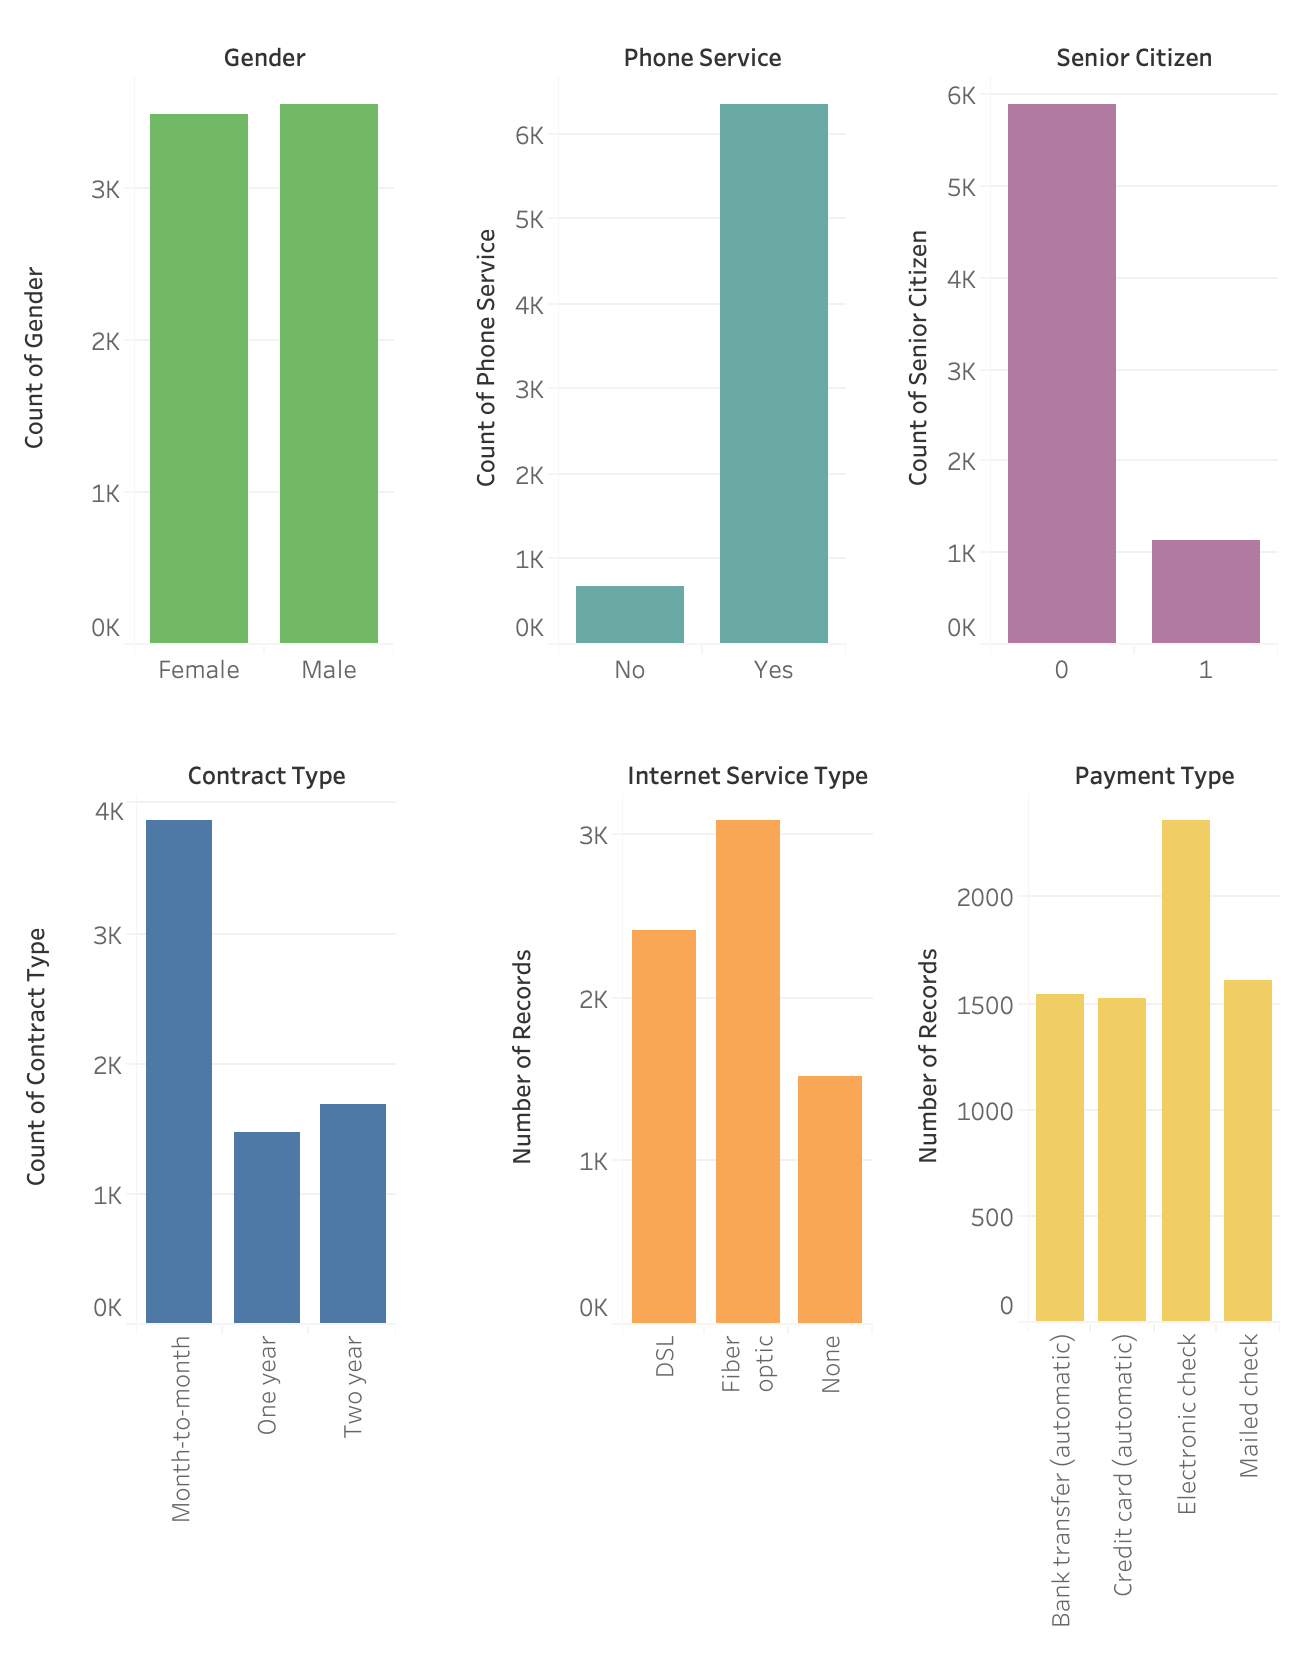

In [11]:
# Some basic Tableau graph exploration
# Wanted to see some of the totals for a few features against one another

from IPython.display import Image
Image(filename="img/tableau_exploration.png", width=800)

Takeaways:
    
- The split between female and male in the dataset is almost equal

- Way more people are signed up for phone service

- Customer base has fewer senior citizens

- Month-to-month is the predominant contract type

- Internet service is favoring fiber optic, but DSL and none are not far behind

- An almost tie for second place among payment types, with electronic check being the only clear favorite

Let's dive deeper.

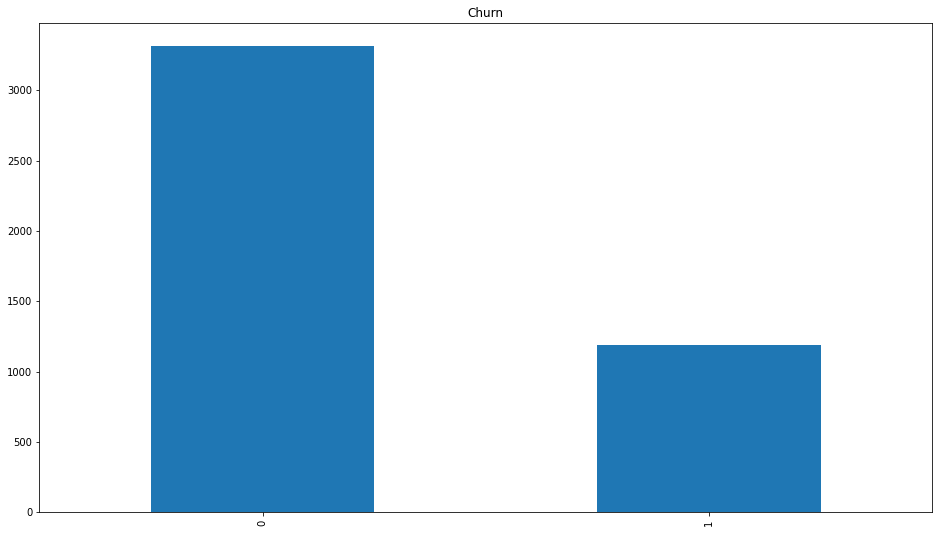

In [12]:
# Let's take a look at what is heppening with just churn.

plt.figure(figsize=(16,9))
X_train.churn.value_counts().plot.bar().set_title("Churn")
plt.show()

In [13]:
# what are our typical monthly revenue is per customer that has churned
mean_charges = X_train[X_train.churn == 1].monthly_charges.mean()
mean_charges

74.86899159663876

In [14]:
# what are the total customers that have churned in our train dataset
churned = X_train[X_train.churn == 1].monthly_charges.count()
churned

1190

In [15]:
mean_charges * churned

89094.10000000014

Takeaway:
    
- Our average monthly revenue per customer is $74.87

- We have 1190 churned customers in our train dataset

- Which means we have potenitally lost somewhere in the neighborhood of $89,094.10 in monthly revenue from these churned customers

In [16]:
# is there correlation in our variables?

X_train.corr()

,gender,senior_citizen,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,tenure_years,phone_and_multi_line,partner_and_dependents,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,DSL,Fiber optic,None,Month-to-month,One year,Two year
gender,1.000000,0.000596,-0.008942,-0.013848,0.006885,-0.029079,-0.011879,-0.003863,-0.019508,-0.006086,0.008035,-0.004172,0.004998,0.007119,0.002279,-0.008996,-0.013346,0.005474,0.015892,-0.006819,0.000981,0.006698,-0.001055,0.009000,-0.007339
senior_citizen,0.000596,1.000000,-0.117105,-0.018954,-0.028216,-0.174685,0.024232,0.046669,0.162936,0.222478,0.097341,0.156382,0.009529,0.125163,-0.151981,-0.008456,-0.031439,0.175443,-0.159482,-0.120502,0.264619,-0.180429,0.142662,-0.039390,-0.127920
online_security,-0.008942,-0.117105,1.000000,0.184183,0.174590,0.283704,0.050905,0.061645,-0.149088,-0.046509,0.261381,-0.291187,0.334211,0.003747,0.165173,0.096398,0.128060,-0.250901,0.062591,0.145750,-0.245519,0.128162,-0.373038,0.125085,0.313477
online_backup,-0.013848,-0.018954,0.184183,1.000000,0.181171,0.210481,0.150048,0.142180,-0.007073,0.115711,0.374726,-0.198685,0.377728,0.109570,0.117780,0.103595,0.082017,-0.132835,-0.032748,0.005600,-0.051920,0.056262,-0.288375,0.121787,0.218462
device_protection,0.006885,-0.028216,0.174590,0.181171,1.000000,0.243138,0.279399,0.288624,-0.039807,0.155958,0.376124,-0.176043,0.366118,0.084642,0.123410,0.085856,0.141213,-0.147406,-0.057455,-0.007778,-0.040670,0.058133,-0.349486,0.133546,0.278123
tech_support,-0.029079,-0.174685,0.283704,0.210481,0.243138,1.000000,0.177468,0.166049,-0.114647,0.000760,0.283167,-0.286854,0.326478,0.007751,0.148327,0.098504,0.117702,-0.256431,0.077063,0.132788,-0.233830,0.129022,-0.409870,0.117087,0.363785
streaming_tv,-0.011879,0.024232,0.050905,0.150048,0.279399,0.177468,1.000000,0.454041,0.083329,0.351437,0.405177,-0.037381,0.301078,0.182385,0.095191,0.051622,0.046566,0.026664,-0.127291,-0.172903,0.159563,0.007092,-0.236530,0.089883,0.188707
streaming_movies,-0.003863,0.046669,0.061645,0.142180,0.288624,0.166049,0.454041,1.000000,0.077004,0.343587,0.401102,-0.034569,0.294345,0.164673,0.073686,0.046217,0.058148,0.014291,-0.119418,-0.163066,0.150586,0.006566,-0.229564,0.095498,0.175289
paperless_billing,-0.019508,0.162936,-0.149088,-0.007073,-0.039807,-0.114647,0.083329,0.077004,1.000000,0.337619,0.153314,0.185343,0.006180,0.120406,-0.089594,-0.007928,-0.023942,0.201361,-0.196835,-0.064024,0.319619,-0.312180,0.169372,-0.065443,-0.134099
monthly_charges,-0.006086,0.222478,-0.046509,0.115711,0.155958,0.000760,0.351437,0.343587,0.337619,1.000000,0.653667,0.199587,0.246102,0.493834,-0.035031,0.052390,0.011434,0.281561,-0.382318,-0.165292,0.787541,-0.760498,0.054071,0.014690,-0.076662


In [17]:
# Though it looks busy, we can use this correlation table to locate some important info
# And the results, are not what we'd expect
X_train.corr().iloc[11].sort_values()[0:10]

tenure_years             -0.351923
Two year                 -0.306832
online_security          -0.291187
tech_support             -0.286854
None                     -0.230512
online_backup            -0.198685
total_charges            -0.195164
partner_and_dependents   -0.186318
device_protection        -0.176043
One year                 -0.175398
Name: churn, dtype: float64

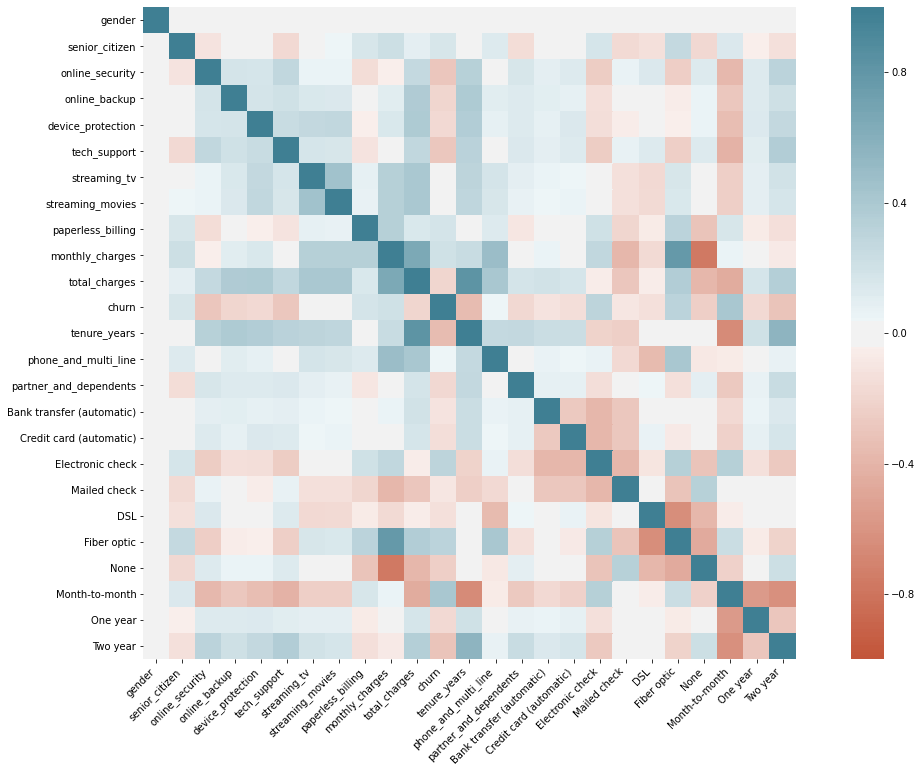

In [18]:
corr = X_train.corr()

plt.figure(figsize=(20,12))

ax = sns.heatmap(
    corr,
    #annot = True,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Takeaways:
    
- We have a ton of variables
- Ideally, we'd like to have variables that are as independent as possible from one another.
- There are a few variables the seem to have weak correlation with one another. We can run a few tests to see if there is any signifigance in those findings. 
-  A few feautures seem to have a bit of correlation, though in the negative direction, which is interesting. Again we can run a few tests on this to provide clarity.
- A possible hypothesis for worth further investigation is the correlation between churn and month-to-month billing.

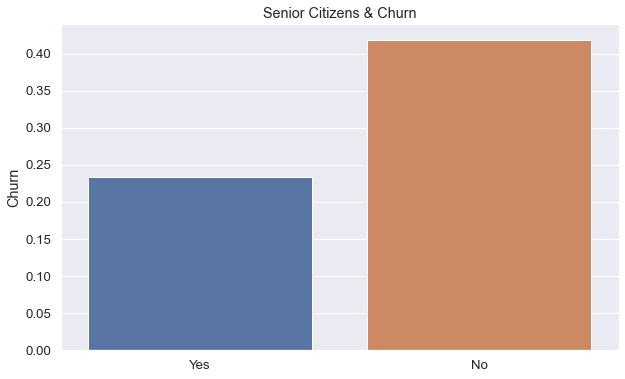

In [19]:
sns.set(font_scale=1.2)
plt.figure(figsize=(10,6))
sns.barplot(X_train.senior_citizen, X_train.churn, data=X_train, ci = None)
plt.title('Senior Citizens & Churn')
plt.ylabel('Churn')
plt.xlabel('')
#plt.xticks(['No', 'Yes'])
plt.xticks(np.arange(2), ('Yes', 'No'))
#plt.xtick.label.set_fontsize(14) 

plt.show()

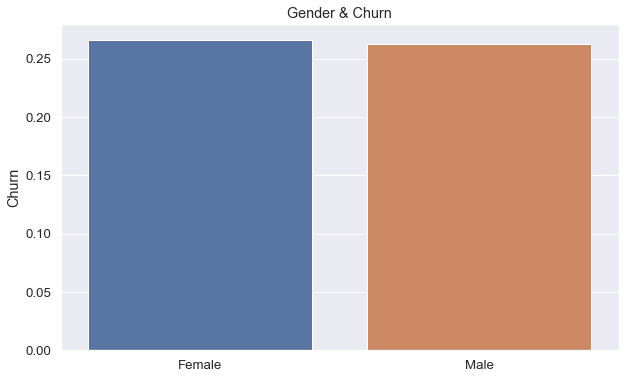

In [20]:

plt.figure(figsize=(10,6))
sns.barplot(X_train.gender, X_train.churn, data=X_train, ci = None)
plt.title('Gender & Churn')
plt.ylabel('Churn')
plt.xlabel('')
plt.xticks(np.arange(2), ('Female', 'Male'))

plt.show()

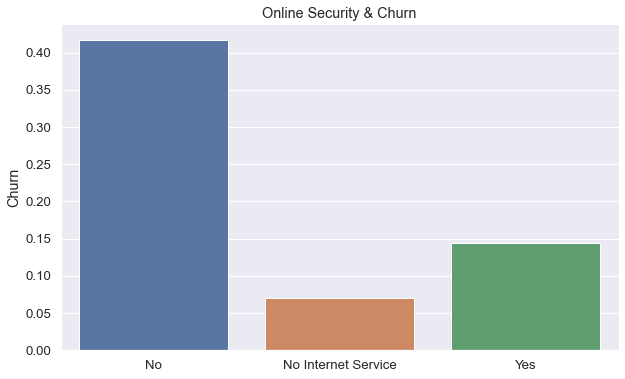

In [21]:
plt.figure(figsize=(10,6))
sns.barplot(X_train.online_security, X_train.churn, data=X_train, ci = None)
plt.title('Online Security & Churn')
plt.ylabel('Churn')
plt.xlabel('')
plt.xticks(np.arange(3), ('No', 'No Internet Service', 'Yes'))

plt.show()

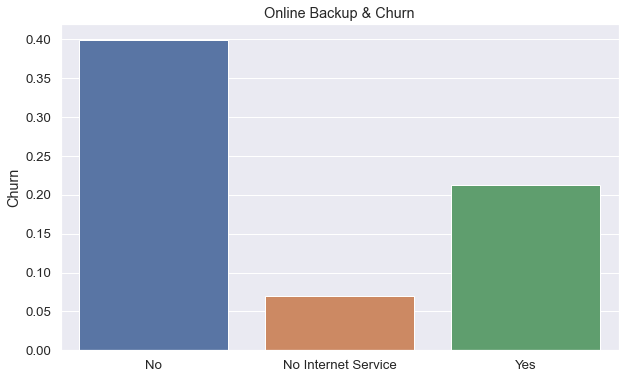

In [22]:
plt.figure(figsize=(10,6))
sns.barplot(X_train.online_backup, X_train.churn, data=X_train, ci = None)
plt.title('Online Backup & Churn')
plt.ylabel('Churn')
plt.xlabel('')
plt.xticks(np.arange(3), ('No', 'No Internet Service', 'Yes'))

plt.show()

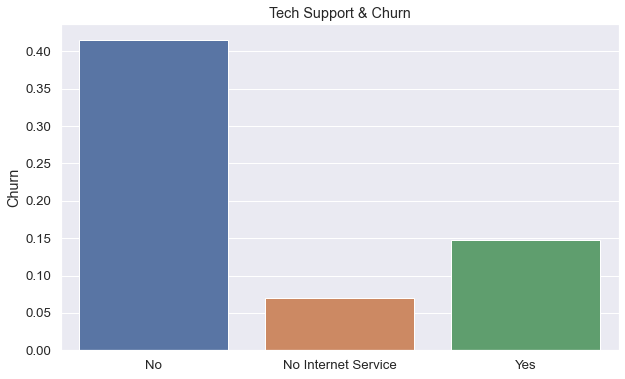

In [23]:
plt.figure(figsize=(10,6))
sns.barplot(X_train.tech_support, X_train.churn, data=X_train, ci = None)
plt.title('Tech Support & Churn')
plt.ylabel('Churn')
plt.xlabel('')
plt.xticks(np.arange(3), ('No', 'No Internet Service', 'Yes'))

plt.show()

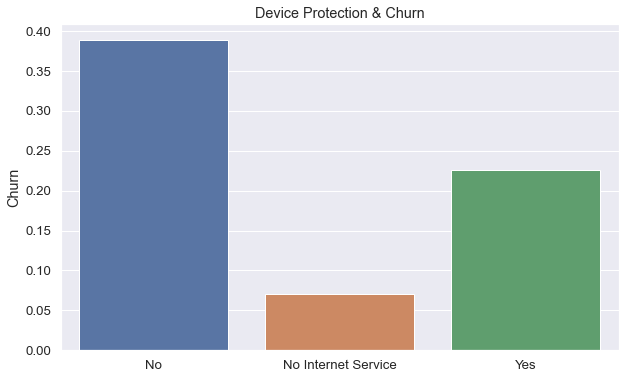

In [24]:
plt.figure(figsize=(10,6))
sns.barplot(X_train.device_protection, X_train.churn, data=X_train, ci = None)
plt.title('Device Protection & Churn')
plt.ylabel('Churn')
plt.xlabel('')
plt.xticks(np.arange(3), ('No', 'No Internet Service', 'Yes'))

plt.show()

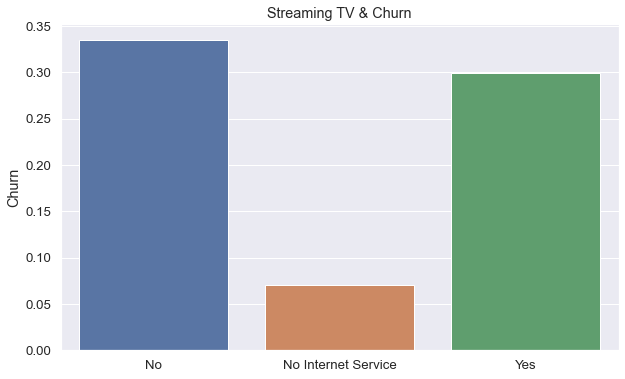

In [25]:
plt.figure(figsize=(10,6))
sns.barplot(X_train.streaming_tv, X_train.churn, data=X_train, ci = None)
plt.title('Streaming TV & Churn')
plt.ylabel('Churn')
plt.xlabel('')
plt.xticks(np.arange(3), ('No', 'No Internet Service', 'Yes'))

plt.show()

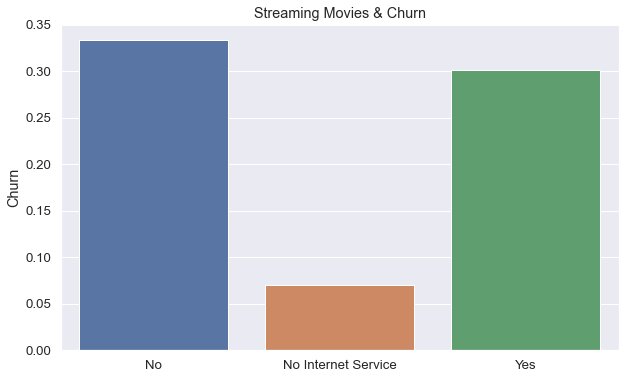

In [26]:
plt.figure(figsize=(10,6))
sns.barplot(X_train.streaming_movies, X_train.churn, data=X_train, ci = None)
plt.title('Streaming Movies & Churn')
plt.ylabel('Churn')
plt.xlabel('')
plt.xticks(np.arange(3), ('No', 'No Internet Service', 'Yes'))

plt.show()

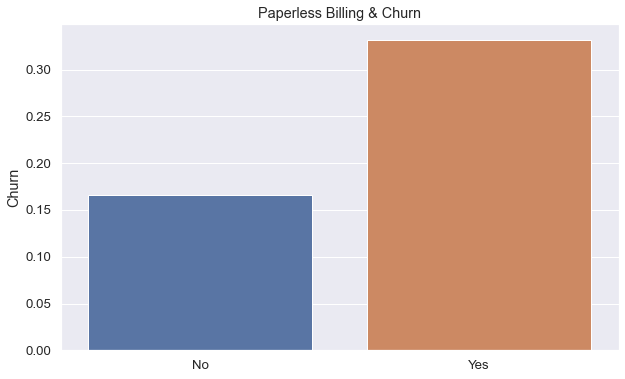

In [27]:
plt.figure(figsize=(10,6))
sns.barplot(X_train.paperless_billing, X_train.churn, data=X_train, ci = None)
plt.title('Paperless Billing & Churn')
plt.ylabel('Churn')
plt.xlabel('')
plt.xticks(np.arange(2), ('No', 'Yes'))

plt.show()

In [28]:
# after reviewing the correlation plots and some of these barplots, we'd like to look at a few crosstabs
# and run some statistical tests

$H_0$: There is no significant correlation between household size and churn.

$H_a$: There is a significant correlation between household size and churn.

$\alpha$ = 0.05

In [29]:
# after reviewing the correlation plots and some of these barplots, we'd like to look at a few crosstabs
# and run some statistical tests

# Chi2-Test for Household Size (0: Single, 1: Partner Only, 2: Dependents Only, 3: Partner & Dependents)

household_size = pd.crosstab(X_train.partner_and_dependents, X_train.churn)
household_size

churn,0,1
partner_and_dependents,,
0,1385,722
1,806,270
2,187,46
3,932,152


In [30]:
chi2, p_household, degf, expected_household = stats.chi2_contingency(household_size)

print(expected_household)
print(f"The p value is: {p_household:.35f}. We reject the null hypotehesis.")

[[1549.81555556  557.18444444]
 [ 791.45777778  284.54222222]
 [ 171.38444444   61.61555556]
 [ 797.34222222  286.65777778]]
The p value is: 0.00000000000000000000000000000000036. We reject the null hypotehesis.


#### Takeaways:
- p-value is less than our alpha ($\alpha = 0.05$). Therefore, as customer segment, household size seems to be statistically significant.
- There's a 47% decrease from the actual churn of partner/dependent churn compared to the expeccted - seems to be a rather high number. Why is this group not churning?
- Single member households have the highest percentage of churn among all the groups.
- Partner only has a 4% increase expected to the observed, not a big number, might be worth further investigation.
- Dependent only has a more than 20% increase expected than observes, which is a bit larger. Certainly worth looking into what might be going on here.

$H_0$: There is no significant correlation between gender and churn.

$H_a$: There is a significant correlation between gender and churn.

$\alpha$ = 0.05

In [31]:
# Chi2-Test for Gender (0: Female, 1: Male)

gender = pd.crosstab(X_train.gender, X_train.churn)
gender

churn,0,1
gender,,
0,1631,592
1,1679,598


In [32]:
chi2, p_gender, degf, expected_gender = stats.chi2_contingency(gender)

print(expected_gender)
print(f"The p value is: {p_gender:.2f}. We fail to reject the null hypothesis.")

[[1635.14  587.86]
 [1674.86  602.14]]
The p value is: 0.81. We fail to reject the null hypothesis.


#### Takeaways:
- p-value is greater than our alpha ($\alpha = 0.05$). The rates of churn vs gender seems almost indistinguishable.
- Not sure it's worth doing more exploration of this segment of the customer base.
- Perhaps a Cramer's V can be done to test the strength of the correlation.

$H_0$: There is no significant correlation between senior citizens and churn.

$H_a$: There is a significant correlation between senior citizens and churn.

$\alpha$ = 0.05

In [33]:
# Chi2-Test for Senior Citizen (0: Senior, 1: Not A Senior)

senior = pd.crosstab(X_train.senior_citizen, X_train.churn)
senior

churn,0,1
senior_citizen,,
0,2874,876
1,436,314


In [34]:
chi2, p_senior, degf, expected_senior = stats.chi2_contingency(senior)

print(expected_senior)
print(f"The p value is: {p_senior:.26f}. We reject the null hypothesis")

[[2758.33333333  991.66666667]
 [ 551.66666667  198.33333333]]
The p value is: 0.00000000000000000000000015. We reject the null hypothesis


### Takeaways:
- p-value is less than our alpha ($\alpha = 0.05$). It would seem our senior_citizen is statistically significant.
- There looks to be a 60% increase in expected vs actually churned customers. This is a very signifigant number. However, the customer base of senior citizen vs non-senior citizen is stark as well. They are not a significant portion of our customer base.

#### Chi squared test for all features

Since the vast majority of variables in the dataset are categorical variables, it would be great to apply the Chi squared test for testing independence between variables.

In [35]:
# Set alpha value
alpha = 0.05

for col in X_train.columns:

    a, b = X_train[col], X_train["churn"]

    observed = pd.crosstab(a, b) 
    chi2, p, degf, expected = stats.chi2_contingency(observed)

    if p < alpha:
        # Reject the null hypothesis
        print("({} and churn) are  dependent of each other. (p = {})".format(col, p))
    else:
         # Failed to reject the null hypothesis
        print("({} and churn) are  independent of each other. (p = {})".format(col, p))


(gender and churn) are  independent of each other. (p = 0.8056180626241757)
(senior_citizen and churn) are  dependent of each other. (p = 1.5432311139815586e-25)
(online_security and churn) are  dependent of each other. (p = 1.16495887174898e-120)
(online_backup and churn) are  dependent of each other. (p = 1.8529124821490668e-86)
(device_protection and churn) are  dependent of each other. (p = 1.3851372601721424e-78)
(tech_support and churn) are  dependent of each other. (p = 2.4370688872957734e-118)
(streaming_tv and churn) are  dependent of each other. (p = 6.745176768523967e-54)
(streaming_movies and churn) are  dependent of each other. (p = 1.0230251788873491e-53)
(paperless_billing and churn) are  dependent of each other. (p = 2.6537820862110215e-35)
(monthly_charges and churn) are  dependent of each other. (p = 1.613428816613666e-10)
(total_charges and churn) are  independent of each other. (p = 0.5306597395541117)
(churn and churn) are  dependent of each other. (p = 0.0)
(tenur

#### Takeaways:

- The majority of variables are dependent with churn, except gender and total_charges are independent with churn.

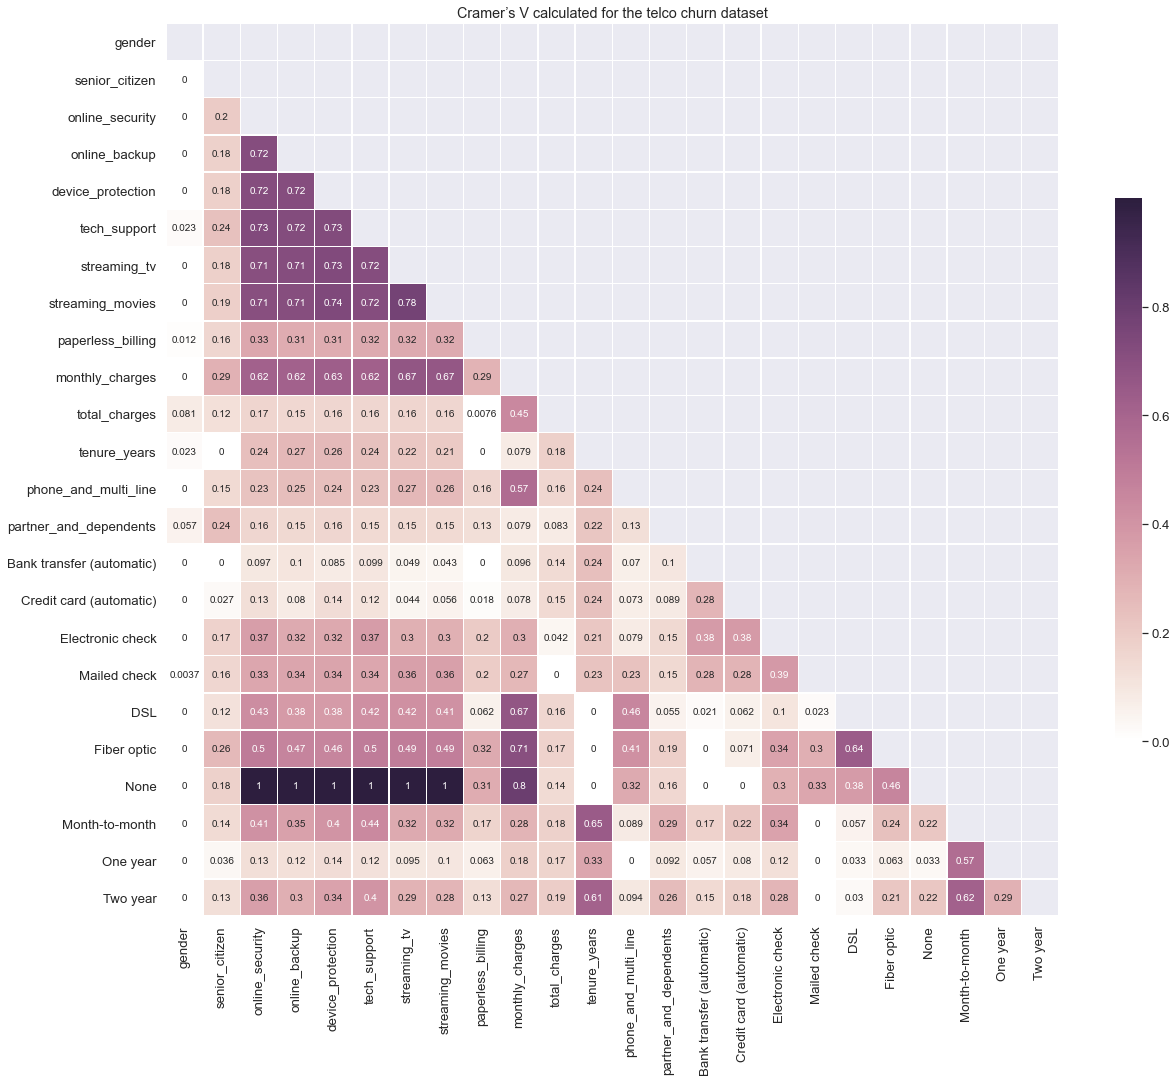

In [50]:
# Cramer's V is a statistic used to measure the strength of association between two nominal variables, 
# and it take values from 0 to 1. Values close to 0 indicate a weak association between the variables
# and values close to 1 indicate a strong association between the variables.

def cramers_corrected_stat(confusion_matrix):
    """
    Calculates the corrected Cramer's V statistic
    
    Args:
        confusion_matrix: The confusion matrix of the variables to calculate the statistic on
    
    Returns:
        The corrected Cramer'v V statistic
    """
    
    chi2, _, _, _ = stats.chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cols = list(X_train.columns.values)
corrM = np.zeros((len(cols),len(cols)))

# Calculate s of every combination of variables
for col1, col2 in itertools.combinations(cols, 2):

    a, b = X_train[col1], X_train[col2]
    
    idx1, idx2 = cols.index(col1), cols.index(col2)
    dfObserved = pd.crosstab(a,b) 
    corrM[idx1, idx2] = cramers_corrected_stat(dfObserved.values)
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)

# Mask to get lower triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.cubehelix_palette(light=1, as_cmap=True)

# Draw the heatmap with the mask 
fig = plt.figure(figsize=(20, 20))

sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.title('Cramer’s V calculated for the telco churn dataset')
plt.show()

Takeaways:

- From the above heatmap: Except gender and total_charges, all features have some kind of association with churn, with varying weights. Nevertheless, the strongest association exists between Month_to_month(contract_type) and tenure, the Cramer's V value is 0.41.


<div class="alert alert-block alert-warning">

<b>Question:</b> Can we isolate some opportunies within groupby segments?

</div>

In [36]:
X_train.groupby(["senior_citizen"])[["churn","monthly_charges","tenure_years"]].mean()

,churn,monthly_charges,tenure_years
senior_citizen,,,
0,0.233600,61.844347,2.706978
1,0.418667,79.827667,2.759111


Takeaway:

- Like previously noted, senior citizens make up a small portion of our train data, but 42% are churning. Also their monthly spend is a bit higher.
- Seems like they average a decent tenure though. So, maybe we can offer some incentives to keep them longer, and reduce the churning.

In [37]:
X_train.groupby(["partner_and_dependents", "Month-to-month", "One year", "Two year"])[["churn","monthly_charges"]].mean()

churn  \
partner_and_dependents Month-to-month One year Two year             
0                      0.0            0.0      1.0       0.036913   
                                      1.0      0.0       0.114206   
                       1.0            0.0      0.0       0.462069   
1                      0.0            0.0      1.0       0.026403   
                                      1.0      0.0       0.144981   
                       1.0            0.0      0.0       0.442460   
2                      0.0            0.0      1.0       0.020000   
                                      1.0      0.0       0.053571   
                       1.0            0.0      0.0       0.330709   
3                      0.0            0.0      1.0       0.020089   
                                      1.0      0.0       0.100000   
                       1.0            0.0      0.0       0.316940   

                                                         monthly_charges  
partner_and_dependents Month-to-month One year Two year                   
0                      0.0            0.0      1.0             55.921141  
                                      1.0      0.0             62.455432  
                       1.0            0.0      0.0             64.061207  
1                      0.0            0.0      1.0             72.400165  
                                      1.0      0.0             76.505019  
                       1.0            0.0      0.0             76.581349  
2                      0.0            0.0      1.0             46.449000  
                                      1.0      0.0             53.023214  
                       1.0            0.0      0.0             53.875591  
3                      0.0            0.0      1.0             57.749777  
                                      1.0      0.0             61.859815  
                       1.0            0.0      0.0             65.546995

Takeaway:

- Single member and Partner Only have the highest avg rate of churn, with the highest going to Single member.
- Month-to-month contract is every segments highest churn position.

In [38]:
X_train.groupby(["Month-to-month", "One year", "Two year", "DSL", "Fiber optic", "None"])[["churn","monthly_charges"]].mean()


churn  \
Month-to-month One year Two year DSL Fiber optic None             
0.0            0.0      1.0      0.0 0.0         1.0   0.009732   
                                     1.0         0.0   0.060932   
                                 1.0 0.0         0.0   0.019560   
               1.0      0.0      0.0 0.0         1.0   0.025751   
                                     1.0         0.0   0.199446   
                                 1.0 0.0         0.0   0.088889   
1.0            0.0      0.0      0.0 0.0         1.0   0.179012   
                                     1.0         0.0   0.555060   
                                 1.0 0.0         0.0   0.317073   

                                                       monthly_charges  
Month-to-month One year Two year DSL Fiber optic None                   
0.0            0.0      1.0      0.0 0.0         1.0         21.669830  
                                     1.0         0.0        104.133154  
                                 1.0 0.0         0.0         70.505257  
               1.0      0.0      0.0 0.0         1.0         20.908369  
                                     1.0         0.0         99.079501  
                                 1.0 0.0         0.0         61.204028  
1.0            0.0      0.0      0.0 0.0         1.0         20.456790  
                                     1.0         0.0         86.926860  
                                 1.0 0.0         0.0         49.885045

Takeaway:

- Once again the highest churn rate is coming from month-to-month contracts. Worth noting these customers also have fiber optic service. Also, fiber optic service is more expensive than DSL.

- Though, we don't think fiber optics alone is a problem, as the churn rate in other contract types are not nearly as high.

- No picket signs necessary for our fiber optic service, just need to work on extending the contract length per customer.

In [39]:
X_train.groupby(["partner_and_dependents",'Electronic check', 'Mailed check', 'Credit card (automatic)',
       'Bank transfer (automatic)'])[["churn","monthly_charges"]].mean()

churn  \
partner_and_dependents Electronic check Mailed check Credit card (automatic) Bank transfer (automatic)             
0                      0.0              0.0          0.0                     1.0                        0.237968   
                                                     1.0                     0.0                        0.216931   
                                        1.0          0.0                     0.0                        0.237477   
                       1.0              0.0          0.0                     0.0                        0.518382   
1                      0.0              0.0          0.0                     1.0                        0.154412   
                                                     1.0                     0.0                        0.125000   
                                        1.0          0.0                     0.0                        0.164062   
                       1.0              0.0          0.0                     0.0                        0.422330   
2                      0.0              0.0          0.0                     1.0                        0.277778   
                                                     1.0                     0.0                        0.109375   
                                        1.0          0.0                     0.0                        0.108434   
                       1.0              0.0          0.0                     0.0                        0.400000   
3                      0.0              0.0          0.0                     1.0                        0.089965   
                                                     1.0                     0.0                        0.081272   
                                        1.0          0.0                     0.0                        0.110687   
                       1.0              0.0          0.0                     0.0                        0.296000   

                                                                                                        monthly_charges  
partner_and_dependents Electronic check Mailed check Credit card (automatic) Bank transfer (automatic)                   
0                      0.0              0.0          0.0                     1.0                              65.127406  
                                                     1.0                     0.0                              63.539947  
                                        1.0          0.0                     0.0                              43.157328  
                       1.0              0.0          0.0                     0.0                              73.942647  
1                      0.0              0.0          0.0                     1.0                              74.647794  
                                                     1.0                     0.0                              73.490530  
                                        1.0          0.0                     0.0                              55.000391  
                       1.0              0.0          0.0                     0.0                              83.418325  
2                      0.0              0.0          0.0                     1.0                              58.537500  
                                                     1.0                     0.0                              50.722656  
                                        1.0          0.0                     0.0                              37.592771  
                       1.0              0.0          0.0                     0.0                              73.203000  
3                      0.0              0.0          0.0                     1.0                              66.136332  
                                                     1.0                     0.0                              63.972792  
                                        1.0          0.0          

Takeaway:

- It seems that electronic checks have the highest churn among payment types.

In [40]:
X_train.groupby(['online_security', 'online_backup','device_protection', 'tech_support'])[["churn","monthly_charges"]].mean()

churn  \
online_security online_backup device_protection tech_support             
0               0             0                 0             0.561125   
                                                2             0.298701   
                              2                 0             0.487805   
                                                2             0.217687   
                2             0                 0             0.420000   
                                                2             0.215385   
                              2                 0             0.329167   
                                                2             0.152439   
1               1             1                 1             0.070248   
2               0             0                 0             0.306931   
                                                2             0.138298   
                              2                 0             0.195122   
                                                2             0.097403   
                2             0                 0             0.183099   
                                                2             0.089041   
                              2                 0             0.122137   
                                                2             0.060000   

                                                              monthly_charges  
online_security online_backup device_protection tech_support                   
0               0             0                 0                   67.264120  
                                                2                   70.331818  
                              2                 0                   79.410801  
                                                2                   80.028571  
                2             0                 0                   75.468000  
                                                2                   78.481923  
                              2                 0                   88.750625  
                                                2                   88.943293  
1               1             1                 1                   21.080527  
2               0             0                 0                   68.430941  
                                                2                   67.486170  
                              2                 0                   76.475203  
                                                2                   81.895130  
                2             0                 0                   74.589437  
                                                2                   76.665753  
                              2                 0                   83.976718  
                                                2                   90.906833

Takeaway:

- Highest churn seems to be among those that don't take advantage of any of the additional services. Maybe they feel stuck or lost with a particular service, then chance since they have no place to turn.

- Those with all four services have the lowest rate of churn.

In [41]:
X_train.groupby(['streaming_tv', 'streaming_movies', 'paperless_billing'])[["churn","monthly_charges"]].mean()

churn  monthly_charges
streaming_tv streaming_movies paperless_billing                           
0            0                0                  0.247544        57.041749
                              1                  0.400749        62.973845
             2                0                  0.227848        74.564873
                              1                  0.363077        77.176462
1            1                0                  0.059172        20.980030
                              1                  0.095890        21.313185
2            0                0                  0.225166        73.677152
                              1                  0.354545        79.029394
             2                0                  0.199396        89.851511
                              1                  0.327940        95.032794

<div class="alert alert-block alert-warning">

<b>Question:</b> Have any features popped up as being more useful for predicting churn?

</div>

Takeaway:

A few features do seem to show a correlation with predicting churn.

- Senior Citizen, specifically if the customer is a senior
- Household size, specifically if it is single memeber, then partner only
- Online Security, only
- Online Backup, only
- Having more than a single premium/additonal feature, particularly all four
- Month-to-month contracts
- Fiber optic service, though this might be due to cost
- Electronic Check payment type

<div class="alert alert-block alert-warning">

<b>Question:</b> As we reviewed the list above, one of the features stood out again and again, month-to-month contracts. What does the churn rate looke like at the end of one year on month-to-month vs a one year contract? 

</div>

In [42]:
# basically right around/right after that one year mark is up
twelve_month_tenure = X_train[(X_train['tenure_years'] >= 1) & (X_train['tenure_years'] <= 1.12)]
twelve_month_tenure.groupby(['Month-to-month', 'One year', 'Two year'])[["churn"]].mean()

churn
Month-to-month One year Two year          
0.0            0.0      1.0       0.000000
               1.0      0.0       0.173913
1.0            0.0      0.0       0.418182

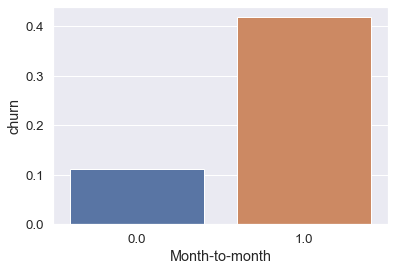

In [43]:
sns.barplot(y="churn", x="Month-to-month", data=twelve_month_tenure, ci=None)
plt.show()

Takeaway:

- Right at, or shortly after, the 12 month period, a much larger portion of the month-to-month have churned.

<a id='baseline_model'></a>

## Create a Baseline Model

Right off the top, we will do is create a dataframe to store all our our predicted values during the modeling process.

The first two data sets to be places will be the actual and the baseline model.

In [44]:
# Remove churn from the data, used during exploration

X_train = X_train.drop(['churn'],axis=1)
X_validate = X_validate.drop(['churn'],axis=1)
X_test = X_test.drop(['churn'],axis=1)

#### Baseline model

- We set the percent of customers who are still with telco as our baseline.

In [51]:
baseline = 1 - y_train.churn.mean()
baseline

0.7355555555555555

Takeaways:

- If we were to assume every customer would stay with telco, the percent that we assumed correctly would be about 74%, the accuracy for our best model should be better than this.


In [45]:
# logistic regression model
model = LogisticRegression().fit(X_train, y_train)
y_pred = model.predict(X_validate)
pd.DataFrame(classification_report(y_validate, y_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.836323,0.669528,0.801778,0.752925,0.791548
recall,0.906440,0.516556,0.801778,0.711498,0.801778
f1-score,0.869971,0.583178,0.801778,0.726574,0.792983
support,823.000000,302.000000,0.801778,1125.000000,1125.000000


#### Logistic Regression

The first model out of the gate will be a logistic regression model. It can be a really effective model for predicting discrete outcomes, so we feel it might perform well.

In [52]:
# from sklearn.linear_model import LogisticRegression. 
#The value of hyperparameter C is choosen as 10 after some trail and errors. This values seems to best optimize f1 score 

logit = LogisticRegression(C=10, random_state = 123)

#Fit the model to the training data
logit.fit(X_train, y_train)

#Estimate whether or not a customer would churn, using the training data (threshold of 0.5)
y_pred = logit.predict(X_train)

# Estimate the probability of customer churn, using the training data
y_pred_proba = logit.predict_proba(X_train)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['no churn', 'churn'], index = X_train.index)

In [53]:
# classification report for training data using threshold of 0.5
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      3310
           1       0.66      0.56      0.61      1190

    accuracy                           0.81      4500
   macro avg       0.76      0.73      0.74      4500
weighted avg       0.80      0.81      0.80      4500



<a id='modeling'></a>

## Create and Compare Different Models

#### Modeling

For this project we'll be exploring the use of a Classification ML Algorithm to predict which customers will churn.

- For our purposes both False positives and False negatives will be important, as is the obvious benefits of True Positives predictions
- False Positives: Telco would provide discounts or marketing spend on customers who would likely not churn
- False Negative: Telco might lose out on retaining a customer, which is a huge hit to revenue
- True Positives: Accuracy with our model will be very important, it will lead of higher, potential, revenues.

With these as our focused efforts moving into the modeling phase, all models will be analyzed with a focus on accuracy, and higher F1 scores, which aims to strike a balance between Precision and Recall. Though both Precision and Recall will also be viewed with noteable regard.

<a id='predict_test'></a>

## Predict on Test Model

<a id='csv_export'></a>

## Exporting CSV with Predictions

In [48]:
Executive Summary

We created a logistic regression model to predict customers who are likely to churn.
The model is able to correctly predict 80% of customers who actually churn.
Customers most likely to churn:
** Month to month contract
** New customers (tenure less than 2 years)
** Have fiber optic internet
Focus resources on retaining ‘new’ customers since company does fine retaining the longer tenured customers

SyntaxError: invalid syntax (<ipython-input-48-9924027b86a9>, line 1)